# Chapter 12 — Survival Analysis (تحليل البقاء)

**What you need:** the dataset used in the chapter (e.g., `ATTRITION DATA_Sheet1.csv`).

## 0) Setup (install + imports)
We install `lifelines` for survival analysis and optional packages for correct Arabic rendering in plots.

In [1]:
# Install required libraries
!pip -q install lifelines arabic-reshaper python-bidi

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.6/300.6 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.3/117.3 kB 4.2 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test

# Arabic rendering helpers for matplotlib (optional but recommended)
try:
    import arabic_reshaper
    from bidi.algorithm import get_display

    def fix_arabic_text(text: str) -> str:
        return get_display(arabic_reshaper.reshape(text))
except Exception:
    # Fallback: return text as-is (plots may show disconnected Arabic letters)
    def fix_arabic_text(text: str) -> str:
        return text

# Colab display options
pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 120)

## 1) Load data (تحميل البيانات)
The chapter reads `ATTRITION DATA_Sheet1.csv`. If you have a different file name, upload it and update the path.

In [3]:
from google.colab import files
uploaded = files.upload()

# Pick the first uploaded CSV automatically (you can override the filename below)
csv_files = [fn for fn in uploaded.keys() if fn.lower().endswith(".csv")]
if not csv_files:
    raise FileNotFoundError("No CSV file uploaded. Please upload the chapter dataset (e.g., ATTRITION DATA_Sheet1.csv).")

csv_path = csv_files[0]
print("Using:", csv_path)

df = pd.read_csv(csv_path)
df.head()

Saving ATTRITION DATA_Sheet1.csv to ATTRITION DATA_Sheet1 (1).csv
Using: ATTRITION DATA_Sheet1 (1).csv


,e_code,status,hire_date,service_agreement,job_level,performance_rating_2018,performance_rating_2017,year_of_birth,gender,distance_from_home,manager_changes,no_of_promotions,risk_of_attrition,potential_rating,bonus,no_courses_taken,time_in_position,awards,signon,manager_sat,employee_sat,salary_2017,salary_2018
0,45631,0,1990-09-17,N,3,4,3,1967,M,0.52,1,2,2,5,0,8,30,N,N,81,80,119968,124173
1,45632,0,1995-10-23,N,2,1,2,1971,M,0.08,4,3,2,5,2242,6,5,N,N,88,84,99330,100822
2,45633,0,1996-03-10,N,2,4,4,1972,M,0.51,2,0,3,3,0,2,53,N,N,83,93,102511,115500
3,45634,0,1998-07-13,N,1,3,3,1968,F,0.81,1,0,2,5,2320,2,36,N,N,86,83,56674,58806
4,45635,0,1991-09-16,N,2,3,3,1961,M,0.06,4,0,2,5,0,10,2,N,N,79,80,122021,122021


## 2) Select core variables (اختيار المتغيرات الأساسية)
The chapter uses: employee code, event status, duration in position (months), and gender.

Because column names vary across datasets, we detect the best matches automatically and then build a tidy `data` frame.

In [4]:
# Try to auto-detect column names used in the chapter
col_candidates = {
    "employee_id": ["e_code", "code_e", "employee_id", "emp_id", "EmployeeID", "Employee_Id"],
    "event":       ["status", "event", "attrition", "Attrition", "left", "Left"],
    "duration":    ["time_in_position", "position_in_time", "time_in_post", "tenure_in_position", "duration", "months_in_position"],
    "group":       ["gender", "Gender", "sex", "Sex"]
}

def pick_col(cands):
    for c in cands:
        if c in df.columns:
            return c
    return None

picked = {k: pick_col(v) for k, v in col_candidates.items()}
missing = [k for k, v in picked.items() if v is None]
print("Detected columns:", picked)
if missing:
    raise KeyError(f"Missing required columns for: {missing}. Available columns: {list(df.columns)[:40]} ...")

data = df[[picked["employee_id"], picked["event"], picked["duration"], picked["group"]]].copy()
data.columns = ["employee_id", "event", "duration", "group"]

# Ensure event is binary (0/1). If it's 'Yes/No' or similar, we map it.
if data["event"].dtype == object:
    map_dict = {"yes":1, "y":1, "true":1, "1":1, "attrition":1, "left":1, "resigned":1,
                "no":0, "n":0, "false":0, "0":0, "stayed":0, "active":0}
    data["event"] = data["event"].astype(str).str.strip().str.lower().map(lambda x: map_dict.get(x, x))
data["event"] = pd.to_numeric(data["event"], errors="coerce")

# Duration numeric
data["duration"] = pd.to_numeric(data["duration"], errors="coerce")

data.head()

Detected columns: {'employee_id': 'e_code', 'event': 'status', 'duration': 'time_in_position', 'group': 'gender'}


,employee_id,event,duration,group
0,45631,0,30,M
1,45632,0,5,M
2,45633,0,53,M
3,45634,0,36,F
4,45635,0,2,M


## 3) Event distribution (توزيع الأحداث)
Count how many employees left (event=1) versus are censored / still employed (event=0).

In [5]:
print("توزيع الأحداث:")
print(data["event"].value_counts(dropna=False))

توزيع الأحداث:
event
0    516
1    170
Name: count, dtype: int64


## 4) Duration distribution + descriptive summary
Histogram of months in position and a brief summary by attrition status.

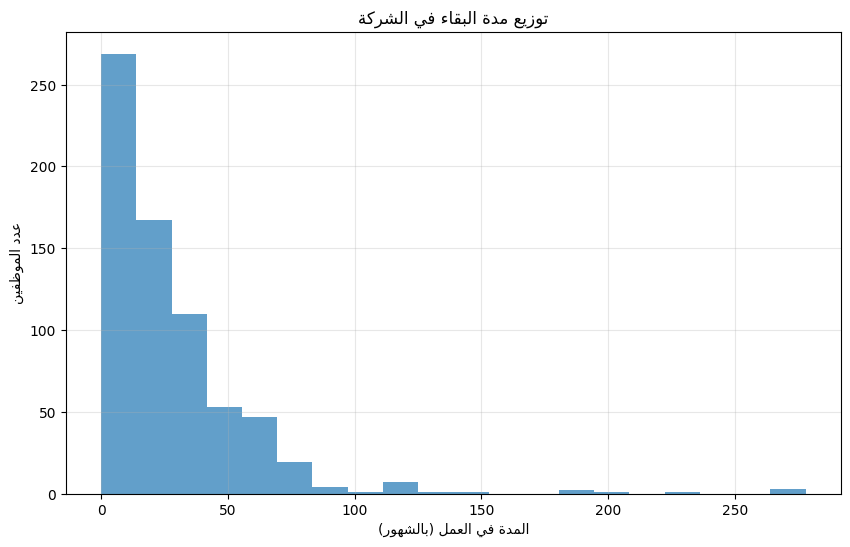

ملخص شهور العمل حسب الاستنزاف:


,mean,std,count
event,,,
0,26.637597,31.837733,516
1,29.494118,29.917687,170


In [6]:
plt.figure(figsize=(10, 6))
plt.hist(data["duration"].dropna(), bins=20, alpha=0.7)
plt.xlabel(fix_arabic_text("المدة في العمل (بالشهور)"))
plt.ylabel(fix_arabic_text("عدد الموظفين"))
plt.title(fix_arabic_text("توزيع مدة البقاء في الشركة"))
plt.grid(True, alpha=0.3)
plt.show()

attrition_summary = data.groupby("event")["duration"].agg(["mean", "std", "count"])
print("ملخص شهور العمل حسب الاستنزاف:")
display(attrition_summary)

## 5) Kaplan–Meier (جميع الموظفين)
Fit and plot the survival function for all employees.

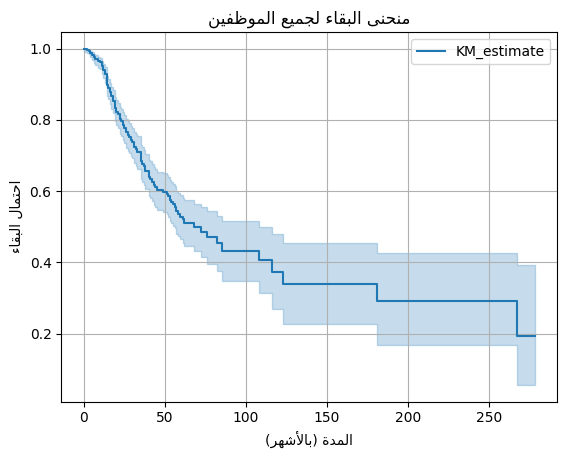

In [7]:
kmf = KaplanMeierFitter()
kmf.fit(durations=data["duration"], event_observed=data["event"])

ax = kmf.plot_survival_function()
plt.title(fix_arabic_text("منحنى البقاء لجميع الموظفين"))
plt.xlabel(fix_arabic_text("المدة (بالأشهر)"))
plt.ylabel(fix_arabic_text("احتمال البقاء"))
plt.grid(True)
plt.show()

## 6) Survival probability at a fixed time point
Compute survival probability at **50 months** and the implied attrition rate up to that point.

In [8]:
time_point = 50
survival_prob = kmf.predict(time_point)

print(f"احتمال البقاء عند {time_point} شهرًا: {survival_prob * 100:.2f}%")
attrition_rate = (1 - survival_prob) * 100
print(f"نسبة المغادرة حتى {time_point} شهرًا: {attrition_rate:.2f}%")

احتمال البقاء عند 50 شهرًا: 59.77%
نسبة المغادرة حتى 50 شهرًا: 40.23%


## 7) Kaplan–Meier by group (الجنس)
Compare survival curves by gender (or whatever grouping column exists in your dataset).

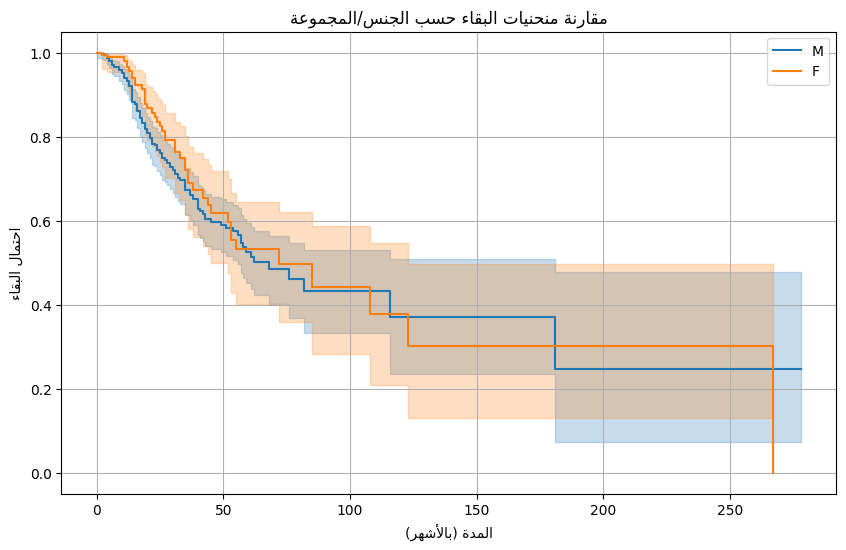

In [9]:
groups = [g for g in data["group"].dropna().unique()]

plt.figure(figsize=(10, 6))
for g in groups:
    subset = data[data["group"] == g]
    kmf.fit(subset["duration"], subset["event"], label=str(g))
    kmf.plot_survival_function(ci_show=True)

plt.title(fix_arabic_text("مقارنة منحنيات البقاء حسب الجنس/المجموعة"))
plt.xlabel(fix_arabic_text("المدة (بالأشهر)"))
plt.ylabel(fix_arabic_text("احتمال البقاء"))
plt.grid(True)
plt.legend()
plt.show()

## 8) Log-rank test (اختبار Log-Rank)
Statistical test for whether the two survival curves differ significantly.

If your dataset uses `M/F`, the code below will detect them; otherwise it will compare the first two groups present.

In [10]:
unique_groups = [g for g in data["group"].dropna().unique()]
if len(unique_groups) < 2:
    raise ValueError("Need at least two groups to run the log-rank test.")

# Prefer M vs F if present; otherwise use first two groups
preferred = None
if set(["M", "F"]).issubset(set(map(str, unique_groups))):
    gA, gB = "M", "F"
else:
    gA, gB = unique_groups[0], unique_groups[1]

group1 = data[data["group"] == gA]
group2 = data[data["group"] == gB]

results = logrank_test(
    group1["duration"], group2["duration"],
    event_observed_A=group1["event"],
    event_observed_B=group2["event"]
)

print("المقارنة بين:", gA, "vs", gB)
print("القيمة الاحتمالية (p-value):", results.p_value)
print("هل الفرق معنوي؟", "نعم" if results.p_value < 0.05 else "لا")

المقارنة بين: M vs F
القيمة الاحتمالية (p-value): 0.4185850839055104
هل الفرق معنوي؟ لا


## 9) Cox Proportional Hazards model (نموذج كوكس للخطر النسبي)
The chapter fits a Cox model with: gender, job level, and performance rating.

This cell tries to locate these columns automatically. If your dataset uses different names, update the candidate lists.

In [11]:
# Candidate columns for the Cox model (edit if your dataset uses different naming)
cox_candidates = {
    "event": ["status", "event", "attrition", "Attrition", "left", "Left"],
    "duration": ["time_in_position", "position_in_time", "duration", "months_in_position"],
    "gender": ["gender", "Gender", "sex", "Sex"],
    "job_level": ["job_level", "level_job", "JobLevel", "level"],
    "perf_rating": ["performance_rating_2018", "rating_perf", "performance_rating", "PerformanceRating"]
}

def pick_any(cands):
    for c in cands:
        if c in df.columns:
            return c
    return None

cox_cols = {k: pick_any(v) for k, v in cox_candidates.items()}
print("Detected Cox columns:", cox_cols)

missing = [k for k, v in cox_cols.items() if v is None]
if missing:
    raise KeyError(f"Missing Cox columns for: {missing}. You can edit `cox_candidates` to match your dataset.")

cox_data = df[[cox_cols["event"], cox_cols["duration"], cox_cols["gender"], cox_cols["job_level"], cox_cols["perf_rating"]]].copy()
cox_data.columns = ["event", "duration", "gender", "job_level", "perf_rating"]

# Ensure numeric types where needed
cox_data["event"] = pd.to_numeric(cox_data["event"], errors="coerce")
cox_data["duration"] = pd.to_numeric(cox_data["duration"], errors="coerce")
cox_data["job_level"] = pd.to_numeric(cox_data["job_level"], errors="coerce")
cox_data["perf_rating"] = pd.to_numeric(cox_data["perf_rating"], errors="coerce")

# Convert categorical gender to dummies (drop_first=True matches the chapter explanation)
cox_data = pd.get_dummies(cox_data, columns=["gender"], drop_first=True)

# Reorder to: duration, event, then covariates
cols = ["duration", "event"] + [c for c in cox_data.columns if c not in ["duration", "event"]]
cox_data = cox_data[cols]

cph = CoxPHFitter()
cph.fit(cox_data, duration_col="duration", event_col="event")
cph.print_summary()

Detected Cox columns: {'event': 'status', 'duration': 'time_in_position', 'gender': 'gender', 'job_level': 'job_level', 'perf_rating': 'performance_rating_2018'}


<lifelines.CoxPHFitter: fitted with 686 total observations, 516 right-censored observations>
             duration col = 'duration'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 686
number of events observed = 170
   partial log-likelihood = -927.70
         time fit was run = 2026-01-13 18:54:23 UTC

---
             coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                    
job_level    0.06      1.06      0.08           -0.09            0.21                0.91                1.23
perf_rating  0.16      1.17      0.07            0.03            0.29                1.03                1.34
gender_M     0.15      1.16      0.18           -0.20            0.50                0.82                1.65

             cmp to    z    p  -log2(p)
covariate                              
job_level      0.00 0.76 0.45      1.16
perf_rating    0.00 2.37 0.02      5.81
gender_M       0.00 0.85 0.40      1.33
---
Concordance = 0.56
Partial AIC = 1861.40
log-likelihood ratio test = 7.17 on 3 df
-log2(p) of ll-ratio test = 3.90

## 10) Model-quality p-value calculation example
The chapter demonstrates converting a `-log2(p)` value (e.g., 3.90) back to `p`.

In [12]:
log2_p = 3.90  # example value from the chapter narrative
p_value = 2 ** (-log2_p)
print(f"p-value: {p_value:.6f}")

p-value: 0.066986


## Notes
1) The analysis assumes `event=1` means the employee left, and `event=0` means censored (still employed).